In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.5.65:46131")
client

Client Scheduler: tcp://10.32.5.65:46131 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 25 Cores: 50 Memory: 287.50 GB


# WMT - $\theta$ budget using xhistogram

In [2]:
import dask
import dask.array as dsa
import gcsfs
import gsw
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import xarray as xr
#import cartopy.crs as ccrs #cartopy coord ref sys
#import cartopy
#import cartopy.feature as cfeature

In [3]:
#loading flux ds
ds_tmp = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/budget_th.zarr'))

#loading surface term ds
ds_tmp_surf_terms = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/budget_surf_th.zarr'))

#loading theta and salt ds
t_s = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/t_s.zarr'))

In [4]:
#merging datasets to be organized
ds = xr.merge([ds_tmp, ds_tmp_surf_terms, t_s])
ds

<xarray.Dataset>
Dimensions:                  (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * XC                       (XC) float32 0.083333336 0.25 ... 359.75 359.9167
  * YC                       (YC) float32 -77.87497 -77.7083 ... -24.7083
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    lin_fs_cor

In [5]:
#rechunking so chunksize=ds.shape of each variable so xhistogram can be happy
ds = ds.chunk({'XC': -1, 'YC': -1, 'Z': -1})
ds

<xarray.Dataset>
Dimensions:                  (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * XC                       (XC) float32 0.083333336 0.25 ... 359.75 359.9167
  * YC                       (YC) float32 -77.87497 -77.7083 ... -24.7083
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    lin_fs_cor

## Tracer Budgets

Here we will do the heat and salt budgets for SOSE. In integral form, these budgets can be written as

$$
\mathcal{V} \frac{\partial S}{\partial t} = G^S_{adv} + G^S_{diff} + G^S_{surf} + G^S_{linfs}
$$


$$
\mathcal{V} \frac{\partial \theta}{\partial t} = G^\theta_{adv} + G^\theta_{diff} + G^\theta_{surf} + G^\theta_{linfs} + G^\theta_{sw}
$$

where $\mathcal{V}$ is the volume of the grid cell. The terms on the right-hand side are called _tendencies_. They add up to the total tendency (the left hand side).

The first term is the convergence of advective fluxes. The second is the convergence of diffusive fluxes. The third is the explicit surface flux. The fourth is the correction due to the linear free-surface approximation. The fifth is shortwave penetration (only for temperature).

### Flux Divergence

First we define a function to calculate the convergence of the advective and diffusive fluxes, since this has to be repeated for both tracers.

## Entire WG column budget

**Do I need to `grid.diff(ds.THETA)`? I don't think so because we don't want to find the difference between each cell point for temperature right? Unless... we want to do that to make theta on the same coord as all the other fluxes**

In [6]:
from xhistogram.xarray import histogram
#histogram?

In [7]:
theta_bins = np.arange(-2, 30, 0.5)
theta_bins

array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,
        3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,
        9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. ,
       14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5,
       20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5, 25. ,
       25.5, 26. , 26.5, 27. , 27.5, 28. , 28.5, 29. , 29.5])

In [8]:
def hist_var(direction, tendency, suffix):
    """Compute histogram of `tendency` flux of tracer `suffix`
    where `tendency` is `ADV` or `DIFF`, `suffix` is `TH` or `SLT`,
    and `direction` is `horiz` or `vert`. Return a new xarray.Dataset."""
    
    var = 'conv_' + direction + '_' + tendency + '_flux_' + suffix
    hist_var = histogram(ds.THETA, bins=[theta_bins], weights=ds[var], dim=['XC', 'YC', 'Z'])
    return hist_var

In [9]:
adv_vert_hist = hist_var('vert', 'adv', 'TH').load()
adv_horiz_hist = hist_var('horiz', 'adv', 'TH').load()
diff_vert_hist = hist_var('vert', 'diff', 'TH').load()
diff_horiz_hist = hist_var('horiz', 'diff', 'TH').load()

In [10]:
ds_hist = xr.merge([adv_horiz_hist.rename('adv_horiz_hist'), 
                    adv_vert_hist.rename('adv_vert_hist'),
                    diff_horiz_hist.rename('diff_horiz_hist'),
                    diff_vert_hist.rename('diff_vert_hist')])
ds_hist

<xarray.Dataset>
Dimensions:          (THETA_bin: 63, time: 438)
Coordinates:
  * time             (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * THETA_bin        (THETA_bin) float64 -1.75 -1.25 -0.75 ... 28.25 28.75 29.25
Data variables:
    adv_horiz_hist   (time, THETA_bin) float64 4.603e+06 4.111e+06 ... 0.0 0.0
    adv_vert_hist    (time, THETA_bin) float64 1.7e+07 1.619e+07 ... 0.0 0.0
    diff_horiz_hist  (time, THETA_bin) float64 4.112e+06 4.309e+06 ... 0.0 0.0
    diff_vert_hist   (time, THETA_bin) float64 3.737e+07 2.272e+07 ... 0.0 0.0

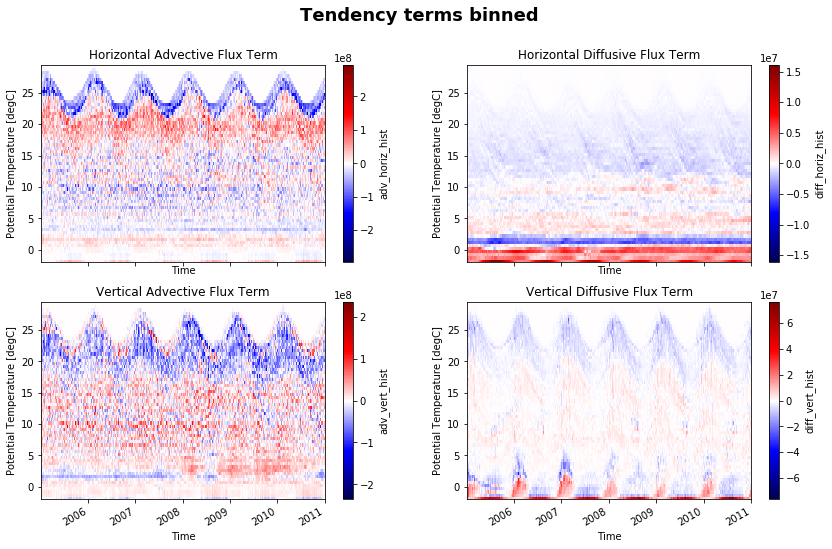

<Figure size 432x288 with 0 Axes>

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14,8))

ds_hist.adv_horiz_hist.transpose().plot(ax=axes[0,0], cmap='seismic')
ds_hist.diff_horiz_hist.transpose().plot(ax=axes[0,1], cmap='seismic')
ds_hist.adv_vert_hist.transpose().plot(ax=axes[1,0], cmap='seismic')
ds_hist.diff_vert_hist.transpose().plot(ax=axes[1,1], cmap='seismic')

fig.suptitle('Tendency terms binned', fontsize=18, fontweight='bold')

axes[0,0].title.set_text('Horizontal Advective Flux Term')
axes[0,1].title.set_text('Horizontal Diffusive Flux Term')
axes[1,0].title.set_text('Vertical Advective Flux Term')
axes[1,1].title.set_text('Vertical Diffusive Flux Term')

plt.show() #this seems to work to make suptitle displayed neatly above
plt.tight_layout();

#### Notes:
- red colors represent positive values so does that mean the water is coming out of the page and negative (blue) values going into the page? Or does it mean the temperatures associated with negative watermasses is being destroyed and transformed into a new temp profile?
- 

## Entire WG column

In [19]:
lower_lat = 0
upper_lat = 78
left_lon = 1788
right_lon = 2159

In [20]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [21]:
ds_wg = ds.isel(**lat_range, **lon_range)
ds_wg

<xarray.Dataset>
Dimensions:                  (XC: 371, YC: 78, Z: 42, time: 438)
Coordinates:
  * XC                       (XC) float32 298.08334 298.25 ... 359.58334 359.75
  * YC                       (YC) float32 -77.87497 -77.7083 ... -65.04163
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    lin_fs_correction_TH

In [22]:
def hist_var(direction, tendency, suffix):
    """Compute histogram of `tendency` flux of tracer `suffix`
    where `tendency` is `ADV` or `DIFF`, `suffix` is `TH` or `SLT`,
    and `direction` is `horiz` or `vert`. Return a new xarray.Dataset."""
    
    var = 'conv_' + direction + '_' + tendency + '_flux_' + suffix
    hist_var = histogram(ds_wg.THETA, bins=[theta_bins], weights=ds_wg[var], dim=['XC', 'YC', 'Z'])
    return hist_var

In [23]:
adv_vert_hist_wg = hist_var('vert', 'adv', 'TH').load()
adv_horiz_hist_wg = hist_var('horiz', 'adv', 'TH').load()
diff_vert_hist_wg = hist_var('vert', 'diff', 'TH').load()
diff_horiz_hist_wg = hist_var('horiz', 'diff', 'TH').load()

In [26]:
ds_hist_wg = xr.merge([adv_horiz_hist_wg.rename('adv_horiz_hist_wg'), 
                    adv_vert_hist_wg.rename('adv_vert_hist_wg'),
                    diff_horiz_hist_wg.rename('diff_horiz_hist_wg'),
                    diff_vert_hist_wg.rename('diff_vert_hist_wg')])
ds_hist_wg

<xarray.Dataset>
Dimensions:             (THETA_bin: 63, time: 438)
Coordinates:
  * time                (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * THETA_bin           (THETA_bin) float64 -1.75 -1.25 -0.75 ... 28.75 29.25
Data variables:
    adv_horiz_hist_wg   (time, THETA_bin) float64 9.843e+05 2.087e+06 ... 0.0
    adv_vert_hist_wg    (time, THETA_bin) float64 6.577e+06 -1.953e+06 ... 0.0
    diff_horiz_hist_wg  (time, THETA_bin) float64 6.577e+05 8.583e+05 ... 0.0
    diff_vert_hist_wg   (time, THETA_bin) float64 2.295e+06 4.009e+06 ... 0.0

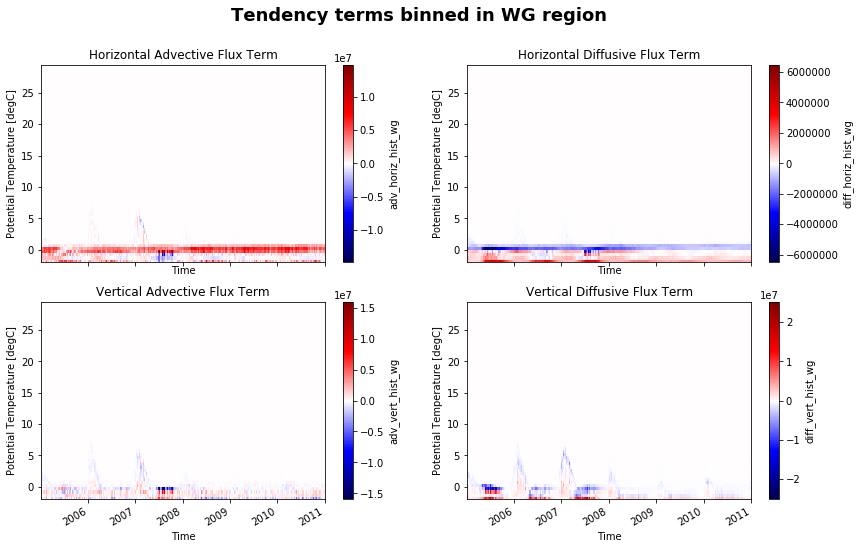

<Figure size 432x288 with 0 Axes>

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14,8))

ds_hist_wg.adv_horiz_hist_wg.transpose().plot(ax=axes[0,0], cmap='seismic')
ds_hist_wg.diff_horiz_hist_wg.transpose().plot(ax=axes[0,1], cmap='seismic')
ds_hist_wg.adv_vert_hist_wg.transpose().plot(ax=axes[1,0], cmap='seismic')
ds_hist_wg.diff_vert_hist_wg.transpose().plot(ax=axes[1,1], cmap='seismic')

fig.suptitle('Tendency terms binned in WG region', fontsize=18, fontweight='bold')

axes[0,0].title.set_text('Horizontal Advective Flux Term')
axes[0,1].title.set_text('Horizontal Diffusive Flux Term')
axes[1,0].title.set_text('Vertical Advective Flux Term')
axes[1,1].title.set_text('Vertical Diffusive Flux Term')

plt.show() #this seems to work to make suptitle displayed neatly above
plt.tight_layout();

In [8]:
sst = ds.THETA.isel(Z=0)
sss = ds.SALT.isel(Z=0)

In [9]:
#converting practical salinity to absolute salinity
sa = xr.apply_ufunc(gsw.SA_from_SP, sss, 0, ds.XC, ds.YC,
                    output_dtypes=[sss.dtype],
                    dask='parallelized').reset_coords(drop=True)
sa

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<SA_from_SP, shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

## Temperature component of global WMT budget

In [11]:
#vertical flux
#ds.TFLUX.isel(**lat_range, **lon_range)
t_flux_z = (ds.TFLUX * coords.rA)#.sum(dim=['XC','YC'])
t_flux_z
#units: W = (kg*m^2)/s^3

<xarray.DataArray (time: 438, YC: 320, XC: 2160)>
dask.array<mul, shape=(438, 320, 2160), dtype=float32, chunksize=(1, 320, 2160), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [12]:
tflux_hist = histogram(sst, bins=[theta_bins], weights=t_flux_z, dim=['XC', 'YC'])
tflux_hist

<xarray.DataArray 'histogram_THETA' (time: 438, THETA_bin: 63)>
dask.array<getitem, shape=(438, 63), dtype=float64, chunksize=(1, 63), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * THETA_bin  (THETA_bin) float64 -1.75 -1.25 -0.75 -0.25 ... 28.25 28.75 29.25

In [13]:
tflux_hist.load()

<xarray.DataArray 'histogram_THETA' (time: 438, THETA_bin: 63)>
array([[-2.05075593e+14,  1.83421487e+14,  5.61046850e+13, ...,
         4.97056179e+11,  0.00000000e+00,  0.00000000e+00],
       [ 5.45212600e+13,  6.71684607e+13,  1.40918240e+14, ...,
         1.14817171e+13,  1.13181220e+12,  1.67468042e+10],
       [ 2.88735633e+13,  7.63403551e+12,  4.40274332e+13, ...,
         2.22324564e+13,  1.75561463e+12,  1.15626656e+11],
       ...,
       [ 2.05555863e+14,  2.54329098e+14,  2.79480096e+14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.04193942e+14,  2.29515763e+14,  3.19661690e+14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.69527092e+14,  1.41454876e+14,  2.65464093e+14, ...,
         2.66566417e+12,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * THETA_bin  (THETA_bin) float64 -1.75 -1.25 -0.75 -0.25 ... 28.25 28.75 29.25

(-2, 10)

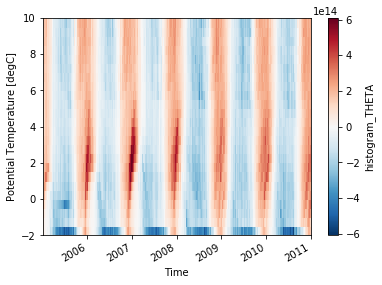

In [14]:
tflux_hist.transpose().plot()
plt.ylim([-2, 10])

In [15]:
sst_hist = histogram(sst, bins=[theta_bins], dim=['XC', 'YC'])
sst_hist.load()

<xarray.DataArray 'histogram_THETA' (time: 438, THETA_bin: 63)>
array([[37443, 14318,  7175, ...,    16,     0,     0],
       [29569,  5526,  8106, ...,   278,    27,     1],
       [22347,  4777,  5976, ...,   490,    61,     7],
       ...,
       [99417,  9067,  9737, ...,     0,     0,     0],
       [88690,  8271, 11193, ...,     0,     0,     0],
       [78852,  6100,  9945, ...,    60,     0,     0]])
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * THETA_bin  (THETA_bin) float64 -1.75 -1.25 -0.75 -0.25 ... 28.25 28.75 29.25

(-2, 10)

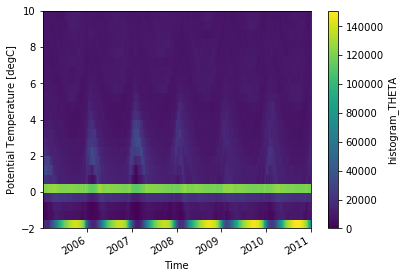

In [16]:
sst_hist.transpose().plot()
plt.ylim([-2, 10])

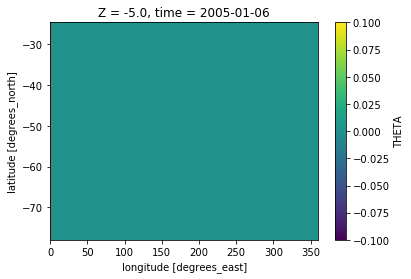

In [16]:
sst[0].isnull().plot()

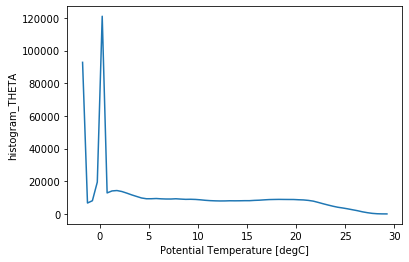

In [17]:
sst_hist.mean(dim='time').plot()

In [17]:
surface_weights = coords.rA*coords.hFacC[0]

In [18]:
sst_hist = histogram(sst, bins=[theta_bins], weights=surface_weights, dim=['XC', 'YC'])
sst_hist.load()

distributed.client - WARNING - Couldn't gather 3 keys, rescheduling {"('getitem-bb4f193fe3a59b43e5fe8a798d2fe8a6', 301, 0)": (), "('getitem-bb4f193fe3a59b43e5fe8a798d2fe8a6', 239, 0)": (), "('getitem-bb4f193fe3a59b43e5fe8a798d2fe8a6', 352, 0)": ()}


<xarray.DataArray 'histogram_THETA' (time: 438, THETA_bin: 63)>
array([[4.39020134e+12, 1.91093564e+12, 9.59001707e+11, ...,
        4.80724640e+09, 0.00000000e+00, 0.00000000e+00],
       [3.39652649e+12, 6.83375743e+11, 1.01634148e+12, ...,
        8.58965797e+10, 8.25841741e+09, 3.05809472e+08],
       [2.52511939e+12, 5.87636940e+11, 7.43738238e+11, ...,
        1.51169442e+11, 1.86107711e+10, 2.12781530e+09],
       ...,
       [1.27710865e+13, 1.42769349e+12, 1.57388822e+12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.11428129e+13, 1.29539480e+12, 1.76820496e+12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.70344858e+12, 9.13199385e+11, 1.55688162e+12, ...,
        1.85591188e+10, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * THETA_bin  (THETA_bin) float64 -1.75 -1.25 -0.75 -0.25 ... 28.25 28.75 29.25

In [ ]:
(sst_hist.mean(dim='time')/surface_weights.sum()).plot()

In [19]:
# volume tendency term
vol_c = coords.hFacC * coords.rA * coords.drF
theta_vol = ds.THETA

# define bins
delta_theta = 0.1
theta_bins = np.arange(-2, 20, delta_theta)

theta_dist = histogram(ds.THETA, bins=[theta_bins],
                       weights=vol_c, dim=['XC', 'YC', 'Z'])
theta_dist

<xarray.DataArray 'histogram_THETA' (time: 438, THETA_bin: 219)>
dask.array<getitem, shape=(438, 219), dtype=float64, chunksize=(1, 219), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * THETA_bin  (THETA_bin) float64 -1.95 -1.85 -1.75 -1.65 ... 19.65 19.75 19.85

In [ ]:
theta_dist.load()

distributed.client - WARNING - Couldn't gather 20 keys, rescheduling {"('getitem-7b1c1b0eefb7685adccdd0b250f13b28', 307, 0)": (), "('getitem-7b1c1b0eefb7685adccdd0b250f13b28', 126, 0)": (), "('getitem-7b1c1b0eefb7685adccdd0b250f13b28', 338, 0)": (), "('getitem-7b1c1b0eefb7685adccdd0b250f13b28', 65, 0)": (), "('getitem-7b1c1b0eefb7685adccdd0b250f13b28', 22, 0)": (), "('getitem-7b1c1b0eefb7685adccdd0b250f13b28', 43, 0)": (), "('getitem-7b1c1b0eefb7685adccdd0b250f13b28', 311, 0)": (), "('getitem-7b1c1b0eefb7685adccdd0b250f13b28', 303, 0)": (), "('getitem-7b1c1b0eefb7685adccdd0b250f13b28', 49, 0)": (), "('getitem-7b1c1b0eefb7685adccdd0b250f13b28', 358, 0)": (), "('getitem-7b1c1b0eefb7685adccdd0b250f13b28', 280, 0)": (), "('getitem-7b1c1b0eefb7685adccdd0b250f13b28', 345, 0)": (), "('getitem-7b1c1b0eefb7685adccdd0b250f13b28', 238, 0)": (), "('getitem-7b1c1b0eefb7685adccdd0b250f13b28', 174, 0)": (), "('getitem-7b1c1b0eefb7685adccdd0b250f13b28', 332, 0)": (), "('getitem-7b1c1b0eefb7685adccdd0b

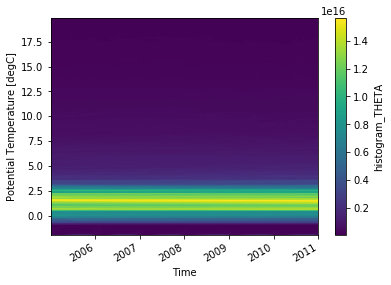

In [22]:
# most of the world's ocean is ~2˚C
# very little variability in temp distribution
theta_dist.plot(x='time')

In [ ]:
# most of the world's ocean is cold (centered ~2˚C)
theta_dist.mean(dim='time').plot()

In [ ]:
# thets distribution anomaly
(theta_dist - theta_dist.mean(dim='time')).plot(x='time')
plt.ylim([-2, 5])

In [ ]:
# cumulative volume
V = theta_dist.cumsum(dim='THETA_bin')
V.plot()

In [ ]:
# avg of cumulative volume
V_mean = V.mean(dim='time')
V_mean.plot()

In [ ]:
# cumulative volume anomaly
V_anom = V - V_mean
V_anom.plot(x='time')
plt.ylim(-2, 7)

In [ ]:
delta_t = 5*24*60*60
dVdt = V_anom.diff(dim='time') / delta_t
#dV/dt
dVdt.plot(x='time', vmax=200e6)
plt.ylim(-2, 7)

In [ ]:
(dVdt.mean(dim='time') / 1e6).plot()

In [ ]:
# one WMT term

runit2mass = 1.035e3 #rho_not
heat_capacity_cp = 3.994e3 #J/˚K/kg
Omega_tflux = tflux_hist / (runit2mass * heat_capacity_cp) / delta_theta

Omega_tflux.plot(x='time', vmax=200e6)

In [ ]:
# psi - side flux term
V_volflux = ds.VVEL.isel(YG=-1) * coords.hFacS.isel(YG=-1) * coords.drF * coords.dxG.isel(YG=-1)
V_volflux

In [ ]:
import xgcm
grid = xgcm.Grid(coords, periodic=['X'])
grid

In [ ]:
theta_s = grid.interp(ds.THETA, 'Y', boundary='extrapolate')
theta_s

In [ ]:
theta_s.data

In [ ]:
# just use cell center for binning transport (rather than interpolating to cell face)
Theta_nb = ds.THETA.isel(YC=-1).reset_coords(drop=True)
Theta_nb

In [ ]:
V_binned = histogram(Theta_nb, bins=[theta_bins], weights=V_volflux, dim=['XC', 'Z'])
V_binned

In [ ]:
V_binned.load()

In [ ]:
V_binned.plot(x='time')

In [ ]:
V_binned.mean(dim='time').plot()

## Temperature component of WG WMT budget

In [ ]:
sst_mean = ds.THETA.isel(Z=0).mean(dim='time')#.load()

In [ ]:
surface_mask = (coords.hFacC[0]>0)#.load()

In [ ]:
sst_mean.where(surface_mask).plot()

In [ ]:
left_lon = 298
upper_lat = -65
right_lon = 360
lower_lat = -78

In [ ]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'facecolor': '0.5'})
(sst_mean.where(surface_mask)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Surface Mask @ ~2km\nLat[290,360]\nLon[-80,-63.5]');

In [ ]:
lower_lat = 0
upper_lat = 78
left_lon = 1788
right_lon = 2159

In [ ]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [ ]:
sst_wg = ds.THETA.isel(**lat_range, **lon_range, Z=0)
sst_wg

In [ ]:
#vertical flux
t_flux_z_wg = (ds.TFLUX.isel(**lat_range, **lon_range) * coords.rA)
t_flux_z_wg
#units: W = (kg*m^2)/s^3

In [ ]:
tflux_hist_wg = histogram(sst_wg, bins=[theta_bins], 
                          weights=t_flux_z_wg, dim=['XC', 'YC'])
tflux_hist_wg

In [ ]:
tflux_hist_wg.load()

In [ ]:
tflux_hist_wg.transpose().plot()
plt.ylim([-2, 10])

In [ ]:
sst_hist_wg = histogram(sst_wg, bins=[theta_bins], dim=['XC', 'YC'])
sst_hist_wg.load()

In [ ]:
sst_hist_wg.transpose().plot()
plt.ylim([-2, 10])

In [ ]:
#WG surface water is mainly made up of waters of -1˚C and -0.2˚C
sst_hist_wg.mean(dim='time').plot()
plt.xlim(-2, 2)

In [ ]:
surface_weights_wg = (coords.rA.isel(**lat_range, **lon_range) *
                   coords.hFacC[0].isel(**lat_range, **lon_range))

In [ ]:
sst_hist_wg_surfweights = histogram(sst_wg, bins=[theta_bins], 
                                    weights=surface_weights_wg, dim=['XC', 'YC'])
sst_hist_wg_surfweights.load()

In [ ]:
(sst_hist_wg_surfweights.mean(dim='time')/surface_weights_wg.sum()).plot()
plt.xlim(-2,-1.3)

In [ ]:
# volume tendency term in WG
vol_c_wg = (coords.hFacC * coords.rA * coords.drF).isel(**lat_range, **lon_range)
theta_vol_wg = ds.THETA

# theta distribution in WG
theta_dist_wg = histogram(ds.THETA.isel(**lat_range, **lon_range), bins=[theta_bins],
                       weights=vol_c_wg, dim=['XC', 'YC', 'Z'])
theta_dist_wg

In [ ]:
theta_dist_wg.load()

In [ ]:
# most of the wg ocean is between -1.0˚C < wg < 1.0˚C
# little variability in temp distribution
theta_dist_wg.plot(x='time')
plt.ylim(-2, 2)

In [ ]:
# most of the wg ocean is cold (centered ~-0.3˚C)
theta_dist_wg.mean(dim='time').plot()
plt.xlim(-2, 2)

In [ ]:
# theta distribution anomaly
(theta_dist_wg - theta_dist_wg.mean(dim='time')).plot(x='time')
plt.ylim([-2, 1.5])

In [ ]:
# cumulative volume
V_wg = theta_dist_wg.cumsum(dim='THETA_bin')
V_wg.transpose().plot()

In [ ]:
# avg of cumulative volume
V_wg_mean = V_wg.mean(dim='time')
V_wg_mean.plot()

In [ ]:
# cumulative volume anomaly
V_wg_anom = V_wg - V_wg_mean
V_wg_anom.plot(x='time', vmax=6e14)
plt.ylim(-2, 7)

In [ ]:
delta_t = 5*24*60*60 #in nanoseconds like the dataset time
dVdt_wg = V_wg_anom.diff(dim='time') / delta_t

dVdt_wg.plot(x='time', vmin=-2e8, vmax=2e8)
plt.ylim(-2, 7)

In [ ]:
#does this mean the main watermass being transformed has temperature of 0˚C
#or does it mean that most water is being transformed to this property
(dVdt_wg.mean(dim='time') / 1e6).plot() # in SV

### diff term

Want to calculate convergence of horizontal diffusive fluxes

$$ - \frac{\partial}{\partial x} F^x_{diff} - \frac{\partial}{\partial y} F^y_{diff} $$

In [ ]:
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

ds_wg = ds.isel(YC=slice(lower_lat, upper_lat), YG=slice(lower_lat, upper_lat),
                XC=slice(left_lon, right_lon), XG=slice(left_lon, right_lon))

import xgcm
grid_wg = xgcm.Grid(ds_wg, periodic=False)
grid_wg

In [ ]:
horizontal_diffusive_heat_flux_convergence = (
    - grid_wg.diff(ds_wg.DFyE_TH, 'Y', boundary='fill')
    - grid_wg.diff(ds_wg.DFxE_TH, 'X', boundary='fill') )

horizontal_diffusive_heat_flux_convergence = \
  horizontal_diffusive_heat_flux_convergence.chunk({'YC': ds_wg.dims['YC'],
                                                    'XC': ds_wg.dims['XC']})

horizontal_diffusive_heat_flux_convergence

In [ ]:
horizontal_diffusive_heat_flux_convergence.data

In [ ]:
horizontal_diffusive_flux_wmt_term = \
   histogram(ds_wg.THETA,
             bins=[theta_bins],
             weights=horizontal_diffusive_heat_flux_convergence,
             dim=['XC', 'YC', 'Z'])

horizontal_diffusive_flux_wmt_term

In [ ]:
horizontal_diffusive_flux_wmt_term.load()

In [ ]:
horizontal_diffusive_flux_wmt_term.plot(x='time', vmax=1e6)
plt.ylim([-2, 2])

In [ ]:

ds_wg.DFyE_TH.diff('YG')

In [ ]:
diff_flux.nbytes / 1e9

In [ ]:
#diffusive flux
#don't sum over dimensions because you need to bin later
diff_flux_y = ds.DFyE_TH.isel(**lon_range, YG=upper_lat)
diff_flux_x = ds.DFxE_TH.isel(**lat_range, XG=right_lon)
print(diff_flux_y.dims)
print(diff_flux_x.dims)

In [ ]:
diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

In [ ]:
vol_c_wg

In [ ]:
diff_dist = histogram(diff_flux, bins=[theta_bins], weights=vol_c_wg, dim=['XG', 'YG', 'Z'])

In [ ]:
diff_dist = histogram(, bins=[teht])

In [ ]:
diff_dist.load()

In [ ]:
# most of the world's ocean is ~2˚C
# very little variability in temp distribution
diff_dist.plot(x='time')

In [ ]:
# most of the world's ocean is cold (centered ~2˚C)
diff_dist.mean(dim='time').plot()

In [ ]:
# thets distribution anomaly
(diff_dist - diff_dist.mean(dim='time')).plot(x='time')
#plt.ylim([-2, 5])